# 1. 参数的更新

神经网络的学习的目的是找到使损失函数的值尽可能小的参数。这是寻找最优参数的问题，解决这个问题的过程称为最优化（optimization）。遗憾的是，神经网络的最优化问题非常难。这是因为参数空间非常复杂，无法轻易找到最优解。而且，在深度神经网络中，参数的数量非常庞大，导致最优化问题更加复杂。

## 1.1 SGD

随机梯度下降法（Stochastic Gradient Descent，SGD）是一般机器学习中应用最多的优化算法，特别是在深度学习中。按照数据生成分布抽取 m 个小批量（独立同分布的）样本，通过计算它们的梯度均值，我们可以得到梯度的无偏估计。SGD 是一个简单的方法，不过比起胡乱地搜索参数空间，也算是“聪明”的方法。

$$ W = W - \eta g $$

这里把需要更新的权重参数记为 $W$，把损失函数 $L$ 关于 $W$ 的梯度记为 $g = \frac{\partial L}{\partial W}$。$\eta$ 表示学习率（learning rate），之前实践中，所使用的都是固定的学习率。若学习率太大，学习曲线会剧烈震荡；相反，如果学习率太小，学习过程会很缓慢，可能会卡在一个相当高的代价值。

### 学习率衰减（learning rate decay）

在实践中，有必要随着时间的推移逐渐降低学习率，一般会线性衰减学习率直到第n次迭代：

$$ \eta_k = (1 - \alpha)\eta_0 + \alpha \eta_n $$

其中 $ \alpha = \frac{k}{n}$，通常 $ \eta_n $ 应设为大约 $\eta_0$的 1%。

现在，我们将 SGD 算法实现为一个名为 SGD 的 Python 类，

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

进行初始化时的参数 lr 表示学习率。代码段中还定义了update(params, grads)方法，这个方法在SGD中会被反复调用。参数 params 和 grads（与之前的神经网络的实现一样）是字典型变量，按 params['W1']、grads['W1'] 的形式，分别保存了权重参数和它们的梯度。

可以按如下方式进行神经网络的参数的更新：

```python
network = TwoLayerNet(...)
optimizer = SGD()    # 优化器对象

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # mini-batch
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

虽然SGD简单容易实现，但是在解决某些问题时可能没有效率。这里思考一下求下面这个函数的最小值的问题。

$$ f(x, y) = \frac{1}{20}x^2 + y^2 \tag{$1$} $$

这个函数梯度的特征是，y 轴方向上大，x 轴方向上小。我们尝试对该函数应用 SGD，从 $(x,y)=(-7, 2)$ 初始点开始搜索，如下图所示，搜索路径呈“之”字形移动。

![img](images/chapter12/SGD.png)

SGD低效的根本原因是，梯度的方向并没有指向最小值的方向。为了改正 SGD 的缺点，下面我们将介绍 Momentum、AdaGrad、Adam 这三种方法来取代SGD。

## 1.2 动量(Momentum)

虽然 SGD 仍然是非常受欢迎的优化方法，但其学习过程有时会很慢。动量方法旨在加速学习，特别是处理小但一致的梯度，或是带噪声的梯度。动量算法积累了之前梯度指数级衰减的移动平均，并且继续沿该方向移动。

动量方法表示如下：
$$ v = \alpha v - \eta g $$
$$ W = W + v $$

之前步长只是梯度乘以学习率，现在步长取决于梯度序列的大小和排列。当许多连续的梯度指向相同的方向时，步长最大。如果动量算法总是观测到梯度 g，那么它会不停加速，直到达到最终速度，其中步长大小为

$$ v_{(n)} =  \alpha^n v_{(0)} -\frac{1-\alpha^n}{1-\alpha}\cdot \eta g \approx -\frac{\eta}{1-\alpha}\cdot g $$

因此将动量的超参数视为 $\frac{1}{1-\alpha}$ 有助于理解。例如，$\alpha = 0.9$ 对应着最大速度10倍于梯度下降算法。和学习率一样，$\alpha$ 也会随着时间不段调整，一般初始值是一个较小的值，随后慢慢变大。

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

和 SGD 的情形相比，动量方法可以更快地朝 x 轴方向靠近，减弱“之”字形的变动程度。这是因为虽然 x 轴方向上受到的力非常小，但是一直在同一方向上受力，所以朝同一个方向会有一定的加速。相反，虽然 y 轴方向上受到的力很大，但是因为交互地受到正方向和反方向的力，它们会互相抵消。

![img](images/chapter12/momentum.png)

## 1.3 AdaGrad (AdaptiveGradient)

学习率衰减的想法，相当于将“全体”参数的学习率值一起降低。AdaGrad 进一步发展了这个想法，针对“一个一个”的参数，赋予其“定制”的值。AdaGrad 会为参数的每个元素适当地调整学习率，与此同时进行学习。

$$ h = h + g^2 $$
$$ W = W - \frac{\eta}{\sqrt {h}} g$$

变量 $h$ 保存了以前所有梯度值的平方和。在更新参数时，通过乘以 $\frac{1}{\sqrt h}$，就可以调整学习的尺度，相当于加了一个约束项 $ \frac{1}{\sqrt{\sum_1^t g_{(t)}^2}} $。

- 当前期 $g$ 较小的时候，约束项较大，能放大梯度；

- 当后期 $g$ 较大的时候，约束项较小，能约束梯度。

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

需要注意的是，最后一行加上了微小值 1e-7，这是为了防止当 self.h[key] 中出现 0 时的情况。

使用AdaGrad解决式（1）的最优化问题，结果如图所示：

![img](images/chapter12/AdaGrad.png)

由图结果可知，函数的取值高效地向着最小值移动。由于 y 轴方向上的梯度较大，因此刚开始变动较大，但是后面会根据这个较大的变动按比例进行调整，减小更新的步伐。因此，y 轴方向上的更新程度被减弱，“之”字形的变动程度有所衰减。

## 1.4 RMSProp

RMSProp算法修改……。RMSProp使用指数衰减平均以丢弃遥远过去的历史梯度，使其能够在找到凸碗状结构后快速收敛，它就像一个初始化于该碗状结构的AdaGrad 算法实例。

$$ h = \rho h + (1 - \rho) g^2 $$
$$ W = W - \frac{\eta}{\sqrt {h}} g$$

In [4]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 1.5 [Adam](https://arxiv.org/abs/1412.6980v8)

Adam (**Ada**ptive **M**oments)是另一种学习率自适应的优化算法，它被看做是 RMSProp 和动量方法的结合。

首先，计算有偏一阶矩估计和有偏二阶矩估计：

$$ m = \beta_1 m + (1-\beta_1) g $$
$$ v = \beta_2 v + (1-\beta_2) g^2 $$

然后，修正矩估计的偏差：

$$ \hat m = \frac{m}{1-\beta_1^t} $$
$$ \hat v = \frac{v}{1-\beta_2^t} $$

最后，计算更新：

$$ W = W - \frac{\eta \hat m}{\sqrt {\hat v}} $$

In [5]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            
            unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            params[key] -= self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

上面我们介绍了 SGD、Momentum、AdaGrad、Adam 几种方法，那么用哪种方法好呢？非常遗憾，（目前）并不存在能在所有问题中都表现良好的方法。这几种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。虽然具有自适应学习率的算法（如 RMSProp）表现得相当鲁棒，但没有哪个算法能脱颖而出。

选择哪一个算法似乎主要取决于使用者对算法的熟悉程序，以便调节超参数。

# 2. 权重的初始值

在神经网络的学习中，权重的初始值特别重要。实际上，设定什么样的权重初始值，往往关系到神经网络的学习能否成功。

## 2.1 可以将权重初始值设为0吗

严格地说，为什么不能将权重初始值设成一样的值呢？

这是因为在误差反向传播法中，所有的权重值都会进行
相同的更新。比如，在 2 层神经网络中，假设第 1 层和第 2 层的权重为0。这样一来，正向传播时，因为输入层的权重为 0，所以第 2 层的神经元全部会被传递相同的值。第 2 层的神经元中全部输入相同的值，这意味着反向传播时第 2 层的权重全部都会进行相同的更新。因此，权重被更新为相同的值，并拥有了对称的值（重复的值）。这使得神经网络拥有许多不同的权重的意义丧失了。

为了防止“权重均一化”（严格地讲，是为了瓦解权重的对称结构），必须随机生成初始值。

# 2.2 隐藏层的激活值的分布

观察隐藏层的激活值（激活函数的输出数据）的分布，可以获得很多启发。这里，我们来做一个简单的实验，观察权重初始值是如何影响隐藏层的激活值的分布的。

这里假设神经网络有 5 层，每层都含有 100 个神经元。然后，用正态分布随机生成 1000 个数据作为输入数据，并把它们传给 5 层神经网络。激活函数使用sigmoid 函数，各层的激活值的结果保存在 activations 字典变量中。最后，使用直方图绘制各层激活值的数据分布。

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

In [7]:
def draw_output(w, activation_func=sigmoid):
    # 随机生成200个数据
    input_data = np.random.randn(200, 100)
    # 5层隐藏层
    hidden_layer_size = 5
    activations = {}  # 用来保存激活值的结果

    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        activations[i] = activation_func(a)

    # 绘制直方图
    plt.figure(figsize=(12, 4))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0:
            plt.yticks([], []) # 不显示y轴刻度
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

起初，我们使用的是标准差为 1 的正态分布初始化权重。

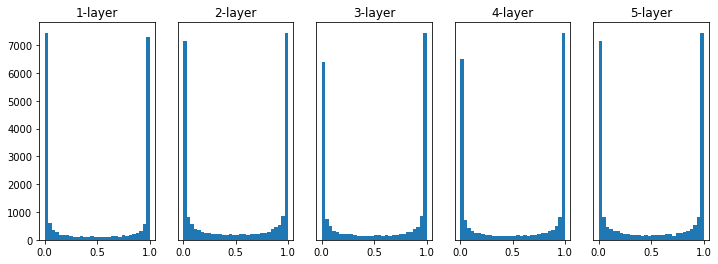

In [8]:
# 各隐藏层的神经元数
node_num = 100
w = np.random.randn(node_num, node_num)
draw_output(w)

各层的激活值呈偏向 0 和 1 的分布。这里使用的 sigmoid 函数随着输出不断地靠近 0（或者靠近1），它的导数的值逐渐接近 0。因此，偏向 0 和 1 的数据分布会造成反向传播中梯度的值不断变小，最后消失。这个问题称为 **梯度消失**（gradient vanishing）。层次加深的深度学习中，梯度消失的问题可能会更加严重。

下面，将权重的标准差设为 0.01，进行相同的实验。

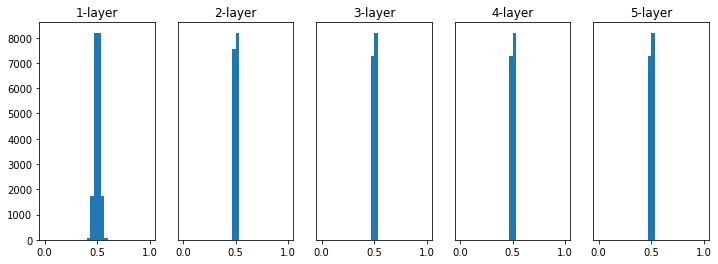

In [9]:
# 改变权重初始值的标准差
w = np.random.randn(node_num, node_num) * 0.01
draw_output(w)

这次数值呈集中在 0.5 附近的分布。因为不像刚才的例子那样偏向 0 和 1，所以不会发生梯度消失的问题。

但是，激活值的分布有所偏向，说明在表现力上会有很大问题。因为如果有多个神经元都输出几乎相同的值，那它们就没有存在的意义了。例如，如果 100 个神经元都输出几乎相同的值，那么也可以由 1 个神经元来表达基本相同的事情。因此，激活值在分布上有所偏向会出现“表现力受限”的问题。

接着，我们尝试使用Xavier Glorot，Yoshua Bengio 的论文 [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html) 中推荐的权重初始值（俗称“Xavier 初始值”），初始值满足下面范围内的均匀分布：

$$ W \sim U[-\frac{\sqrt{6}}{\sqrt{n_j+n_{j+1}}}, \frac{\sqrt{6}}{\sqrt{n_j+n_{j+1}}}] $$

其中，$U$ 代表均匀分布，$n_j$ 为第 $j$ 层神经元个数。

现在，在一般的深度学习框架中，Xavier 初始值已被作为标准使用。

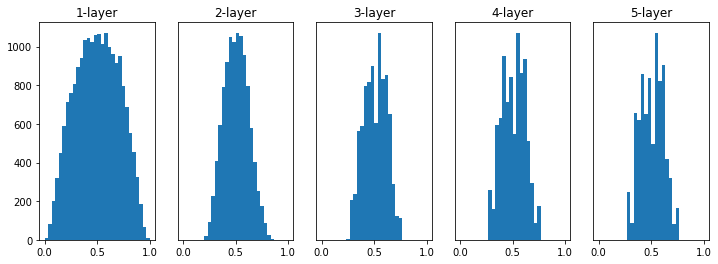

In [10]:
# uniform distribution
w = np.random.uniform(-np.sqrt(6.0/200), np.sqrt(6.0/200), (node_num, node_num))
draw_output(w)

还有一种简化的 Xavier 实现方式是，只使用了前一层的输入节点进行计算。如果前一层的节点数为n，则权重初始值使用标准差为 $\frac{1}{\sqrt{n}}$ 的正态分布。

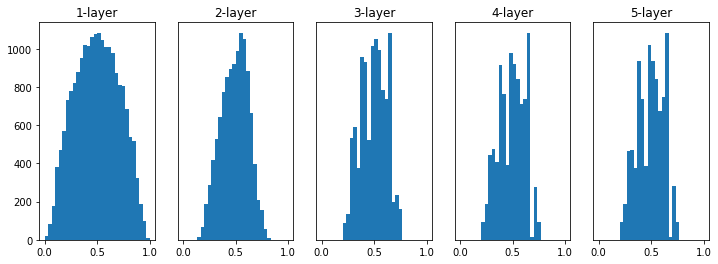

In [11]:
# normal distribution
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
draw_output(w)

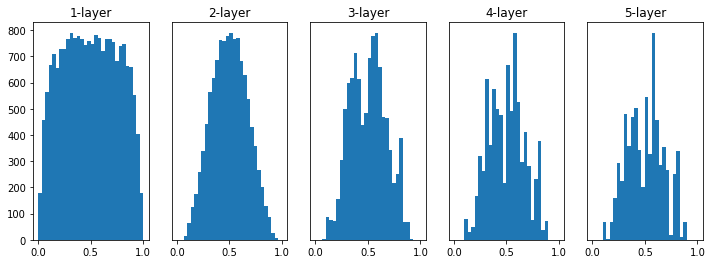

In [12]:
w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
draw_output(w)

## 2.3 ReLU的权重初始值

Xavier 初始值是以激活函数是线性函数为前提而推导出来的。因为 sigmoid 函数和 tanh 函数左右对称，且中央附近可以视作线性函数，所以适合使用Xavier 初始值。

但当激活函数使用 ReLU 时，一般推荐使用 ReLU 专用的初始值，也就是 Kaiming He 等人推荐的初始值，也称为“He初始值”。当前一层的节点数为 n 时，He 初始值使用标准差为的高斯分布。当 Xavier 初始值是时，（直观上）可以解释为，因为ReLU的负值区域的值为0，为了使它更有广度，所以需要 2 倍的系数。

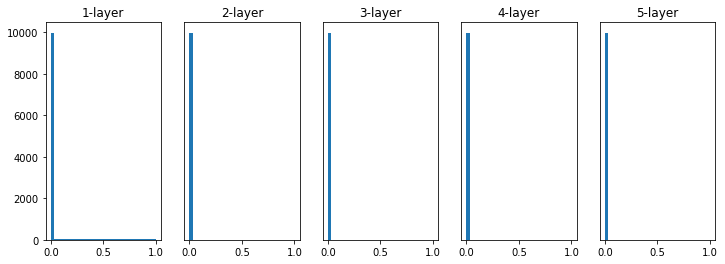

In [14]:
w = np.random.randn(node_num, node_num)
draw_output(w, ReLU)

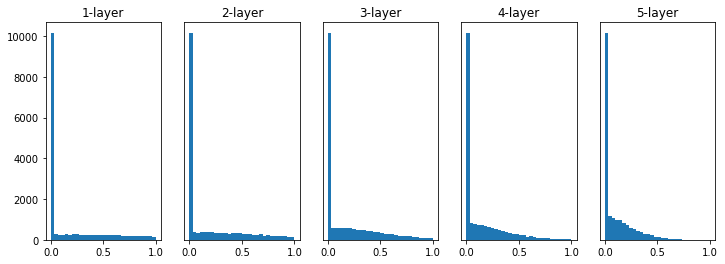

In [15]:
# normal distribution
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
draw_output(w, ReLU)

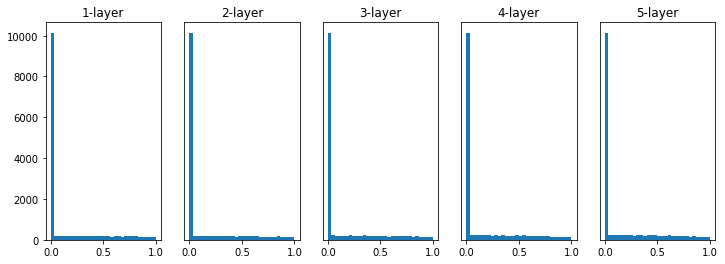

In [16]:
# normal distribution
w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
draw_output(w, ReLU)

观察实验结果可知，当“std = 0.01”时，各层的激活值非常小。神经网络上传递的是非常小的值，说明逆向传播时权重的梯度也同样很小。这是很严重的问题，实际上学习基本上没有进展。

Xavier 初始值时的情况下，随着层的加深，偏向一点点变大，学习时会出现梯度消失的问题。而当初始值为 He 初始值时，各层中分布的广度相同。由于即便层加深，数据的广度也能保持不变，因此逆向传播时，也会传递合适的值。

总结一下，当激活函数使用 ReLU 时，权重初始值使用He初始值，当激活函数为 sigmoid 或 tanh 等 S 型曲线函数时，初始值使用 Xavier 初始值。

## 2.4 基于MNIST 数据集的权重初始值的比较